In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[toy_text]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3132 sha256=723e72a216891368afe92cc14410996c6ce1b3c4b874f5d715f6435e0aaa6f87
  Stored in directory: /root/.cache/pip/wheels/f1/0a/2a/86955ea711b461ab7918236fed2568733f75ed677d0524b56c
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 4.0 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=3ae1eec466e753b66a4e8bf0ea3c7445b5764649253cfc1400d616477637290e
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2

In [2]:
# Setup Environment
import gym
from colabgymrender.recorder import Recorder
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
from tqdm import tqdm
import os 
import numpy.ma as ma
from numpy.core.getlimits import inf
from collections import defaultdict
from gym.spaces import Space, Discrete
import random 
import matplotlib.pyplot as plt
import sys

os.environ["SDL_VIDEODRIVER"] = "dummy"

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1687552/45929032 bytes (3.7%)4325376/45929032 bytes (9.4%)7012352/45929032 bytes (15.3%)9674752/45929032 bytes (21.1%)12222464/45929032 bytes (26.6%)15007744/45929032 bytes (32.7%)17752064/45929032 bytes (38.7%)20430848/45929032 bytes (44.5%)23117824/45929032 bytes (50.3%)25755648/45929032 bytes (56.1%)28418048/45929032 bytes (61.9%)31252480/45929032 bytes (68.0%)339

In [3]:
class Agent(object):
  def __init__(self, state_space: Space, action_space: Space, discount_rate: float):
    self._state_spacee = state_space
    self._action_space = action_space
    self._discount_rate = discount_rate
    self._prev_action = None
    self._prev_state = None

In [ ]:
# Utils
def get_epsilon_greedy_policy_from_action_values(action_values : np.array, epsilon: Optional[float] = 0.0) -> np.array:
  optimal_actions = np.argmax(action_values, axis=-1)
  num_actions = action_values.shape[-1]
  policy = np.full(action_values.shape, epsilon / num_actions)
  if optimal_actions.ndim == 0:
    policy[optimal_actions] += 1.0 - epsilon
  elif optimal_actions.ndim == 1:
    for i, j in enumerate(optimal_actions):
      policy[i, j] += 1.0 - epsilon
  else:
    raise NotImplementedError
  return policy

def get_state_values_from_action_values(action_values : np.array, policy: Optional[np.array] = None) -> np.array:
  if policy is None:
    #assume greedy policy
    policy = get_epsilon_greedy_policy_from_action_values(action_values)
  state_values = np.sum(action_values * policy, axis=1)
  return state_values

def plot_history(history: list):
  plt.figure(0, figsize=(16,4))
  plt.title("average reward per step")
  history_smoothed = [np.mean(history[max(0, i-max_episode//10): i+1]) for i in range(len(history))]
  plt.plot(history)
  plt.plot(history_smoothed)


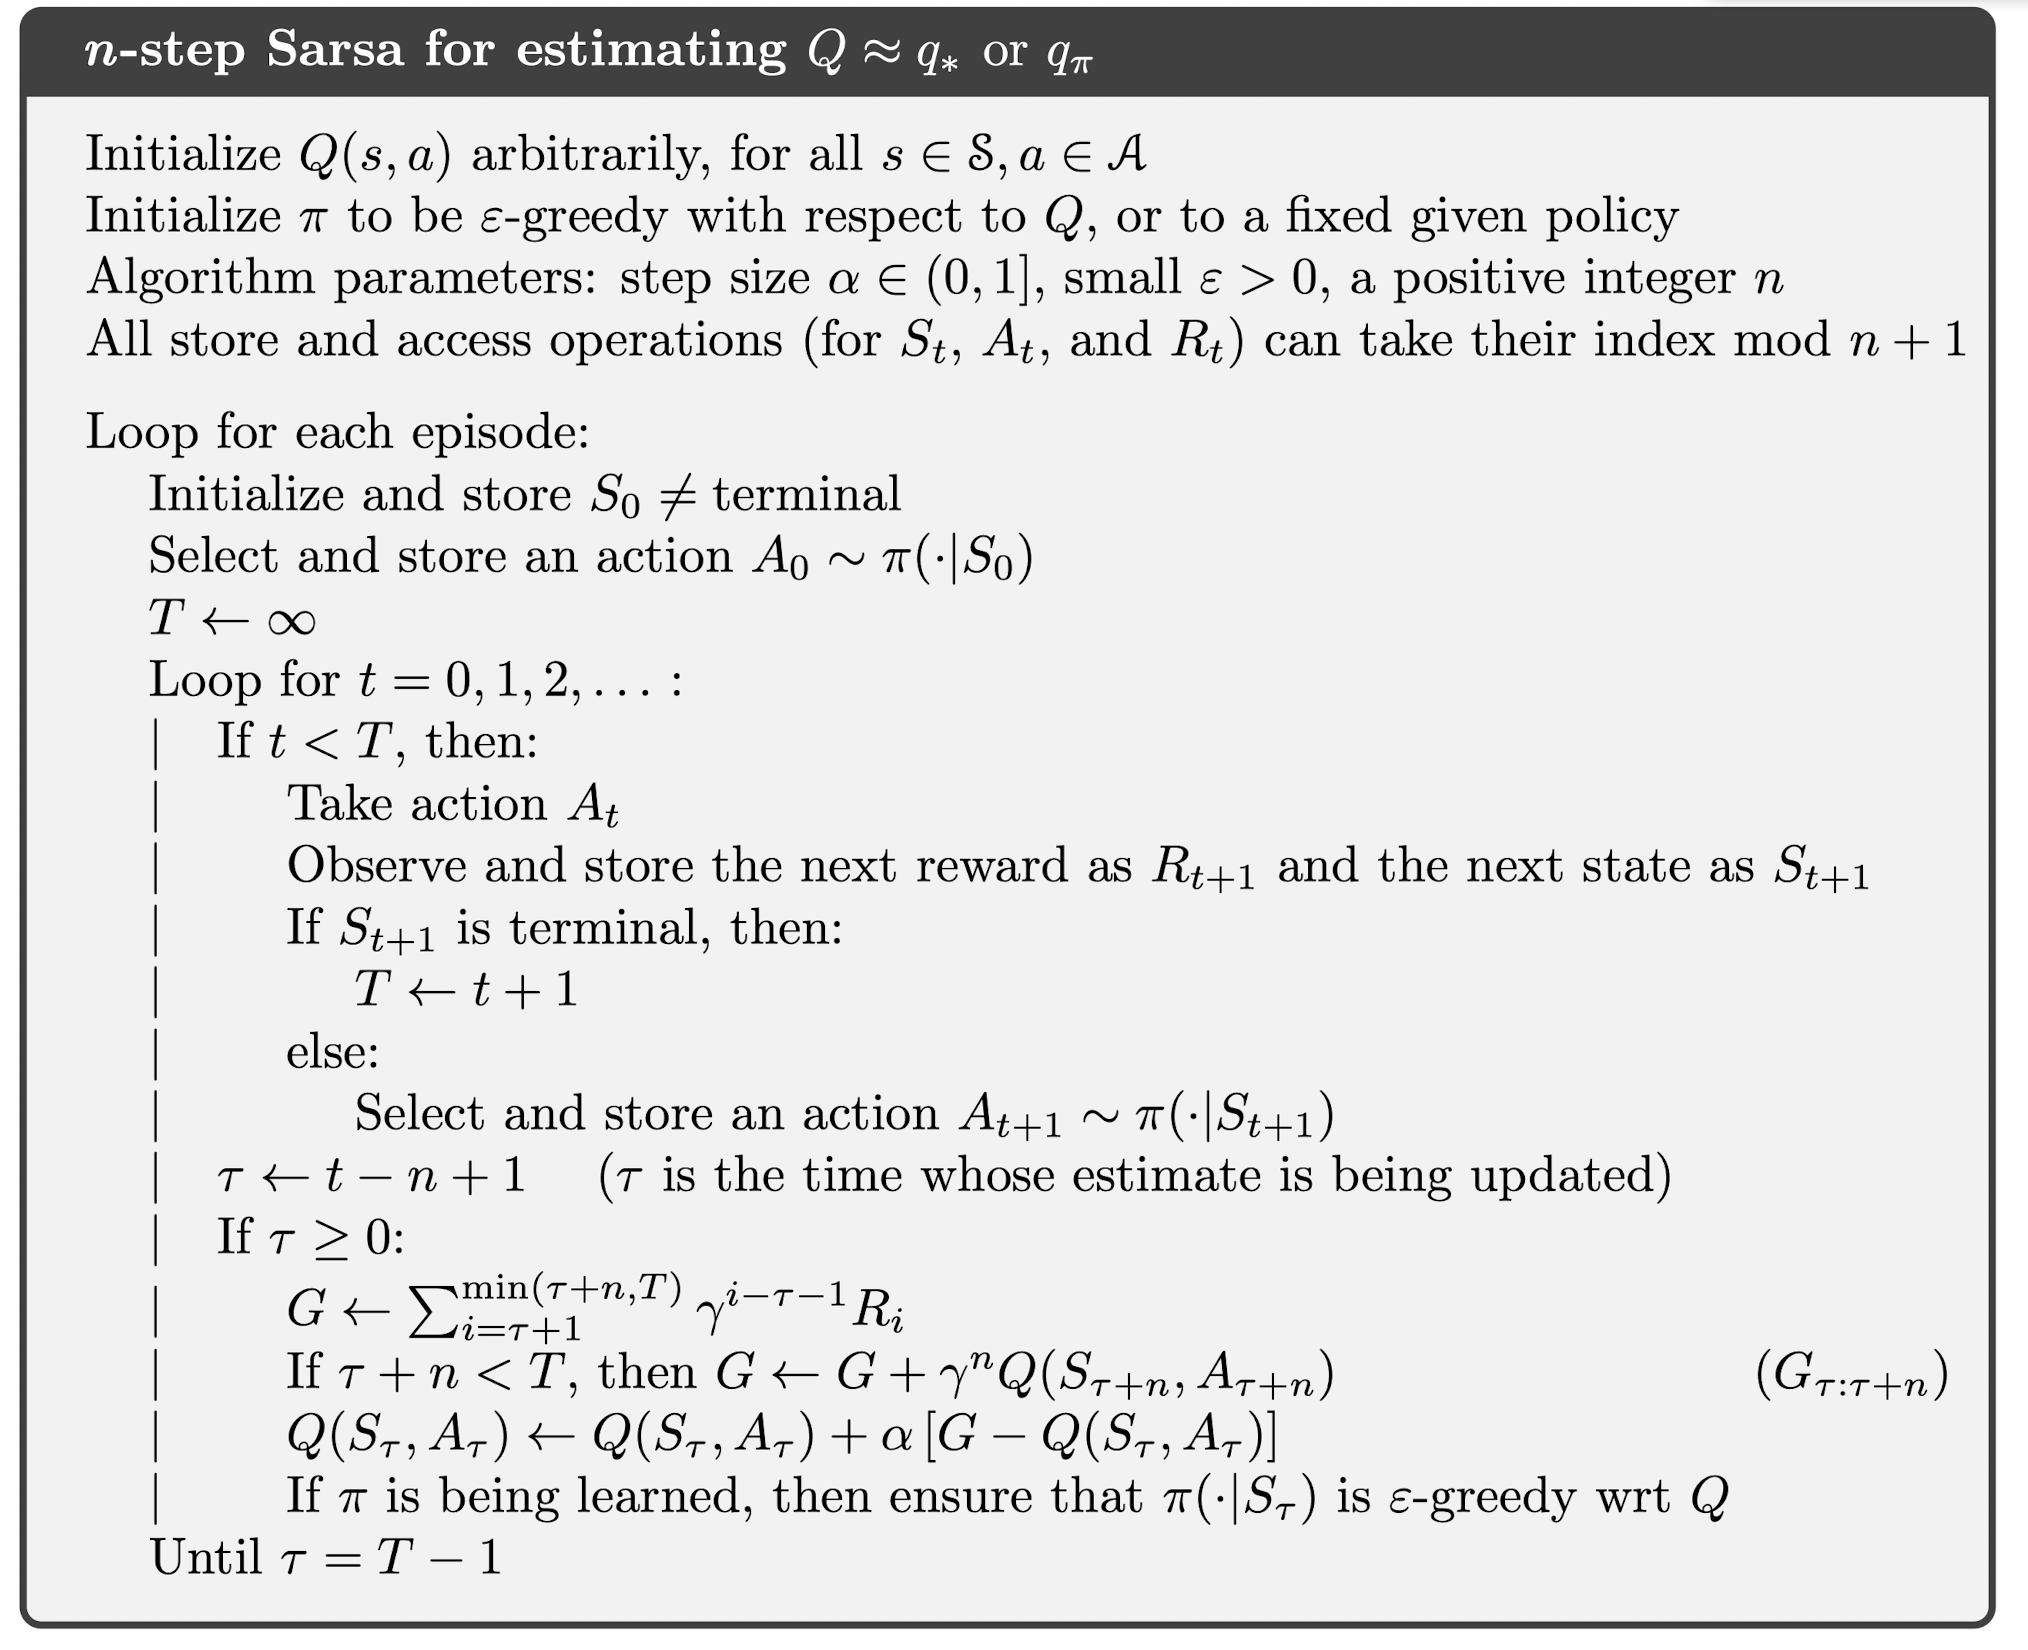

In [5]:
class nStepSarsaAgent(Agent):
  def __init__(self, state_space: Discrete, action_space: Discrete, discount_rate: float, epsilon:float, step_size:float, n:int):
    super().__init__(state_space, action_space, discount_rate) 
    self._epsilon = epsilon
    self._step_size = step_size 
    self._n = n
    # action values
    self._Q = np.random.rand(state_space.n, action_space.n) #np.full((state_space.n, action_space.n), 0.0) 
    # policy
    self._policy = get_epsilon_greedy_policy_from_action_values(self._Q, self._epsilon)
    self.reset()

  def reset(self):
    self._actions = []
    self._states = []
    self._rewards = [0.0]

  def sample_action(self, state) -> int:
    action = np.random.choice(len(self._policy[state]), p = self._policy[state])
    self._actions.append(action)
    return action 

  def record(self, state, reward: Optional[int] = None):
    self._states.append(state)
    if reward is not None:
      self._rewards.append(reward)
  
  def control(self, t: int, T: int):
    n = self._n
    # state that is visited at time step tao will be updated (it's n step before t)
    tao = t - n + 1
    if tao >= 0:
      # calculate returns G
      G = 0
      for i in range(tao+1, min(tao+n, T)+1):
        G += (self._discount_rate ** (i-tao-1)) * self._rewards[i]
      # if episode has not finished, add the approximation of all future discoutned return using Q
      if tao + n < T:
        G += (self._discount_rate ** n) * self._Q[self._states[tao+n], self._actions[tao+n]]
      # update Q value 
      self._Q[self._states[tao], self._actions[tao]] += self._step_size * (G - self._Q[self._states[tao], self._actions[tao]])
      # update policy of updated state 
      self._policy[self._states[tao]] = get_epsilon_greedy_policy_from_action_values(self._Q[self._states[tao]], self._epsilon) 
    return tao == T-1

def test_n_step_sarsa_agent():
  np.random.seed(0)
  agent = nStepSarsaAgent(
    state_space=Discrete(4), 
    action_space=Discrete(4), 
    discount_rate=1.0,
    epsilon=0.2,
    step_size=1.0,
    n=1
  )
  agent._states = [0, 0]
  agent._actions = [0, 1]
  agent._rewards = [0,2]
  tao = 0
  G = agent._rewards[1] + agent._discount_rate * agent._Q[0, 1]
  Q = agent._Q[0,0] 
  Q += agent._step_size * (G - Q)
  done = agent.control(0,10)
  np.testing.assert_equal(Q, agent._Q[0,0])

  print("test_n_step_sarsa_agent passed!")
  
test_n_step_sarsa_agent() 

test_n_step_sarsa_agent passed!


In [6]:
def play_episode(agent: Agent, env: gym.Env):
  state = env.reset()
  agent.reset()
  agent.record(state)
  t = 0
  T = sys.maxsize
  action = agent.sample_action(state)
  stop = False
  while not stop:
    if t < T: 
      new_state, reward, terminal, info = env.step(action)
      agent.record(new_state, reward)
      if terminal:
        T = t + 1
      else:
        action = agent.sample_action(new_state)
    stop = agent.control(t, T)
    t += 1
  
  if reward != 0 and False: 
    print(agent._states)
    print(agent._actions)
    print(agent._rewards)
    xx 
  return reward, T-1


  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  0%|          | 1/2000 [00:00<30:50,  1.08it/s]

step 0, total reward 0.0, efficiency 0.0


  5%|▌         | 102/2000 [00:26<04:12,  7.52it/s]

step 100, total reward 25.0, efficiency 0.06666666666666667


 10%|█         | 202/2000 [00:47<04:20,  6.91it/s]

step 200, total reward 92.0, efficiency 0.07692307692307693


 15%|█▌        | 301/2000 [01:09<08:24,  3.37it/s]

step 300, total reward 158.0, efficiency 0.0


 20%|██        | 402/2000 [01:33<08:44,  3.04it/s]

step 400, total reward 221.0, efficiency 0.0


 25%|██▌       | 502/2000 [02:01<04:47,  5.21it/s]

step 500, total reward 241.0, efficiency 0.0


 30%|███       | 600/2000 [02:20<08:38,  2.70it/s]

step 600, total reward 297.0, efficiency 0.0


 35%|███▌      | 702/2000 [02:45<04:18,  5.02it/s]

step 700, total reward 362.0, efficiency 0.019230769230769232


 40%|████      | 802/2000 [03:09<03:12,  6.24it/s]

step 800, total reward 433.0, efficiency 0.03333333333333333


 45%|████▌     | 901/2000 [03:32<04:40,  3.92it/s]

step 900, total reward 500.0, efficiency 0.0


 50%|█████     | 1001/2000 [03:57<04:15,  3.91it/s]

step 1000, total reward 561.0, efficiency 0.0


 55%|█████▌    | 1102/2000 [04:17<02:16,  6.59it/s]

step 1100, total reward 628.0, efficiency 0.041666666666666664


 60%|██████    | 1202/2000 [04:39<01:57,  6.79it/s]

step 1200, total reward 701.0, efficiency 0.06666666666666667


 65%|██████▌   | 1302/2000 [05:00<01:35,  7.30it/s]

step 1300, total reward 779.0, efficiency 0.058823529411764705


 70%|███████   | 1401/2000 [05:22<03:35,  2.78it/s]

step 1400, total reward 846.0, efficiency 0.0


 75%|███████▌  | 1501/2000 [05:43<01:53,  4.41it/s]

step 1500, total reward 913.0, efficiency 0.030303030303030304


 80%|████████  | 1601/2000 [06:07<03:02,  2.19it/s]

step 1600, total reward 957.0, efficiency 0.0


 85%|████████▌ | 1702/2000 [06:30<01:06,  4.46it/s]

step 1700, total reward 1014.0, efficiency 0.024390243902439025


 90%|█████████ | 1801/2000 [06:53<01:05,  3.05it/s]

step 1800, total reward 1079.0, efficiency 0.0


 95%|█████████▌| 1901/2000 [07:13<00:29,  3.39it/s]

step 1900, total reward 1153.0, efficiency 0.0


100%|██████████| 2000/2000 [07:37<00:00,  4.37it/s]
  result = np.fromstring(s, dtype='uint8')




rewarding episodes: 1213.0


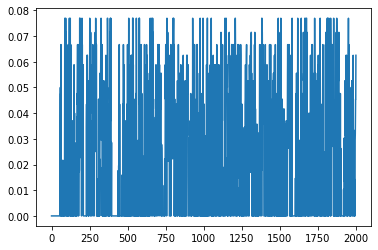

In [9]:
### Off policy learning ###
# Create Environment.
#env = gym.make('Taxi-v3')
reset_agent = True
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False)
directory = './video'
env = Recorder(env, directory)
if reset_agent:
  agent = nStepSarsaAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9,
    epsilon=0.2,
    step_size=0.5,
    n = 5
  )
  history = []
  total_reward = 0

# start playing
max_episode = 2000
for i in tqdm(range(max_episode)):
  reward, steps = play_episode(agent, env)
  history.append(reward / steps)
  total_reward += reward
  if i % 100 == 0:
    print(f"step {i}, total reward {total_reward}, efficiency {history[-1]}")


print(f"\nrewarding episodes: {total_reward}")
plt.plot(history)

env.play()


In [8]:
# Plot the action values.
# cliff walking
#shape = (4,12,4)
# frozen lake
## small
shape = (4,4,4)
## large
#shape = (8,8,4)
direction = {
  0:"LEFT",
  1:"DOWN",
  2:"RIGHT",
  3:"UP"
}
actions = np.argmax(agent._policy, axis=1)
actions = actions.reshape(shape[:2])
named_actions = np.chararray(actions.shape, itemsize=4)
map = [[""] * shape[1]] * shape[0]
for idx, val in np.ndenumerate(actions):
  named_actions[idx] = direction[val]
  #map[idx[0]][idx[1]] = direction[val]
print(named_actions)

action_values = agent._Q.reshape(shape)
num_actions = action_values.shape[-1]
plt.figure(2, figsize=(16,4))
plt.suptitle("action_values (Q)")
for i in range(num_actions):
  plt.subplot(1, num_actions,i+1)
  plt.title(f"{i}, {direction[i]}")
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')
  #print(action_values[:,:,i])


plt.figure(3)
state_values = get_state_values_from_action_values(agent._Q, agent._policy)
plt.imshow(state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")


ValueError: ignored

# Summary

## Temporal Difference on policy learning 
Temporal difference combines Monte Carlo with dynamic programming.
```
V(s) = V(s) + learning_rate * (reward + discount_rate * V(s') - V(s))
```
The last part is also called TD-error:
```
td_error = (reward + discount_rate * V(s') - V(s))
```

### Sarsa
Sarsa requires `(state, action, reward, next_state, next_action)` to update action_values `_Q` and use that to create a epsilon-greedy policy `_policy`.

What makes it on-policy learning is that fact that `next_action` is both 
1. the action the agent is taking  -> behavior policy
2. the action the agent is using to update the action values `_Q` (policy evluation) -> target policy

The conflict is that 1 requires exploration to learn from unexplored environment. But 2 is affected by such exploration (because next action will not always be the optimal one, affecting the value of `_Q`). 


